In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

## Data free examples, trying to match a prior

In [285]:
PI = np.pi

def sample_n(mu, sigma):
    eps = torch.randn_like(mu)
    z = mu + eps * sigma
    return z

class ImplicitMixer(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.noise_dim = noise_dim
        
        self.model = nn.Sequential(nn.Linear(noise_dim, 30),
                                   nn.ReLU(),
                                   nn.Linear(30, 60),
                                   nn.ReLU(),
                                   nn.Linear(60, 30),
                                   nn.ReLU(),
                                   nn.Linear(30, 1))
    
    def forward(self, noise):
        return self.model(noise)
    
class CondQNormal(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma
    
    def forward(self, mean):
        eps = torch.randn_like(mean)
        z = mean + eps * self.sigma
        return z
    
    def density(self, x, mean):
        a = (1 / (np.sqrt(2 * np.pi) * self.sigma))
        b = torch.exp(- torch.pow(x - mean, 2.) / 
                      (2 * self.sigma ** 2.))
        return a * b

def train(mixer, qcond, optimizer, K=20, J=10, iter=100):
    for epoch in range(iter):
        eps = torch.randn((K, mixer.noise_dim))
        psi = mixer(eps)
        optimizer.zero_grad()
        loss = 0
        for j in range(J):
            eps_j = torch.randn((1, mixer.noise_dim))
            psi_j = mixer(eps_j)
            z_j = qcond(psi_j)
            log_H = -torch.log((qcond.density(z_j, mean = psi).sum() + 
                    qcond.density(z_j, mean = psi_j) / (K+1)))
            log_p = -.5 * torch.abs(z_j)  # laplace distribution
            loss -= (log_H + log_p) / J

        loss.backward()
        optimizer.step()
                
    return mixer, qcond

In [286]:
qcond = CondQNormal(1)

K = 20
J = 10
noise_dim = 1
mixer = ImplicitMixer(noise_dim)
optimizer = torch.optim.Adam(mixer.parameters(), lr = .002, 
                             betas=(.5, .999))

In [310]:
mixer, qcond = train(mixer, qcond, optimizer, K=50, J=10, iter=50)

In [314]:
xx = np.arange(-10,10,0.01)
yy = [.25 * np.exp(-0.5 * np.abs(r)) for r in xx]
n_plot_samples = 1000
eps = torch.randn((n_plot_samples, mixer.noise_dim))
z = qcond(mixer(eps))

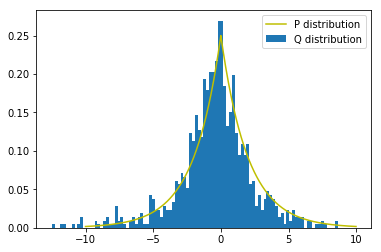

In [315]:
ax=plt.figure()
ax=plt.hist(z.detach().numpy(), density=True, label = 'Q distribution',
            bins = 100)
ax=plt.plot(xx,yy,'y-',label='P distribution')
plt.legend()

In [153]:
normal = torch.distributions.Normal(1, 1)
normal.log_prob(-1)

tensor(-2.9189)

In [151]:
torch.log(qcond.density(-1., mean = torch.ones(1)))

tensor([-2.9189])